<a href="https://colab.research.google.com/github/alzaidawi/PORTAL_code/blob/main/CNN_pore_types_pixel_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
2/2 [==============================] - 2s 33ms/step - loss: 115.2953 - accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 0s 30ms/step - loss: 4.1617e-04 - accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 82ms/step
Predicted pore type: Type

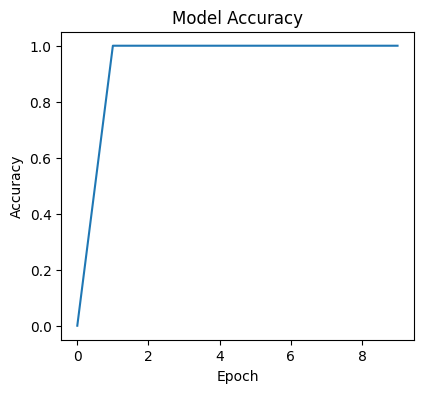

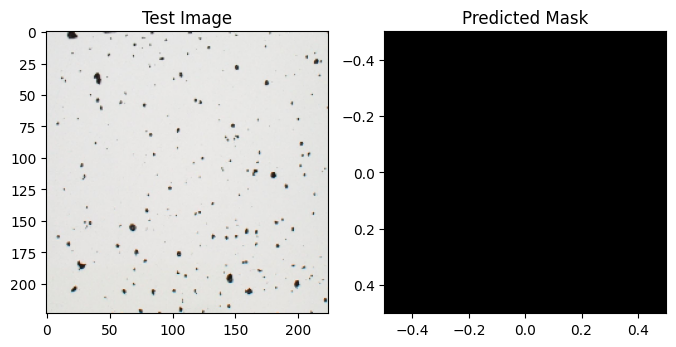

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load and preprocess images and masks
def load_and_preprocess_image(image_path, mask_path=None, target_size=(224, 224)):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    if mask_path is not None:
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=target_size, color_mode='grayscale')
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        return image, mask
    return image

# Load and preprocess training data
train_images = []
train_masks = []

for i in range(2):
    image_path = f"/content/train/image{i+1}.JPG"
    mask_path = f"/content/masks/mask{i+1}.JPG"
    image, mask = load_and_preprocess_image(image_path, mask_path)
    train_images.append(image)
    train_masks.append(mask)

train_images = np.array(train_images)
train_masks = np.array(train_masks) / 255.0  # Normalize masks

# Load and preprocess test data
test_image_path = "/content/test/test_image.JPG"
test_image = load_and_preprocess_image(test_image_path)
test_image = np.array([test_image])

# Model Architecture
model = models.Sequential()

model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Use sparse categorical crossentropy for integer labels

# Training
train_labels = np.array([0, 1])  # Replace with your actual labels

history = model.fit(train_images, train_labels, epochs=10, batch_size=1)

# Plot accuracy over epochs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# ...

# Prediction
prediction = model.predict(test_image)
predicted_class = np.argmax(prediction)

classes = ['Type 1', 'Type 2', 'Type 3', 'Type 4']
predicted_label = classes[predicted_class]
print("Predicted pore type:", predicted_label)

# Show the predicted mask
predicted_mask = model.predict(test_image)
predicted_mask = np.argmax(predicted_mask, axis=-1)
predicted_mask = np.squeeze(predicted_mask)  # Remove singleton dimensions

# Map class labels to grayscale values
grayscale_values = [0, 85, 170, 255]
predicted_mask = np.vectorize(lambda x: grayscale_values[x])(predicted_mask)

# Ensure predicted_mask is a 2D array
if len(predicted_mask.shape) == 3:
    predicted_mask = predicted_mask.squeeze()

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_image[0].astype('uint8'))
plt.title('Test Image')

# Convert predicted_mask to a grayscale image
import PIL.Image

# Ensure predicted_mask is a 2D array
if len(predicted_mask.shape) == 3:
    predicted_mask = predicted_mask.squeeze()

# Reshape to match the expected shape of an image
predicted_mask_reshaped = np.expand_dims(predicted_mask, axis=-1)

# Convert the predicted mask to a PIL image
predicted_mask_image = PIL.Image.fromarray(predicted_mask_reshaped.astype(np.uint8), mode='L')  # 'L' mode for grayscale

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask_image, cmap='gray')
plt.title('Predicted Mask')
plt.show()


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 93s 93s/step - loss: 0.7138 - accuracy: 0.0140
Epoch 2/10
1/1 [==============================] - 90s 90s/step - loss: 0.5336 - accuracy: 0.9337
Epoch 3/10
1/1 [==============================] - 89s 89s/step - loss: 0.1549 - accuracy: 0.9337
Epoch 4/10
1/1 [==============================] - 90s 90s/step - loss: 0.0586 - accuracy: 0.9337
Epoch 5/10
1/1 [==============================] - 89s 89s/step - loss: 0.0543 - accuracy: 0.9337
Epoch 6/10
1/1 [==============================] - 88s 88s/step - loss: 0.0582 - accuracy: 0.9337
Epoch 7/10
1/1 [==============================] - 92s 92s/step - loss: 0.0537 - accuracy: 0.9337
Epoch 8/10
1/1 [==============================] - 90s 90s/step - loss: 0.0452 - accuracy: 0.9337
Epoch 9/10
1/1 [==============================] - 91s 91s/step - loss: 0.0462 - accuracy: 0.9337
Epoch 10/10
1/1 [==============================] - 2s 2s/step


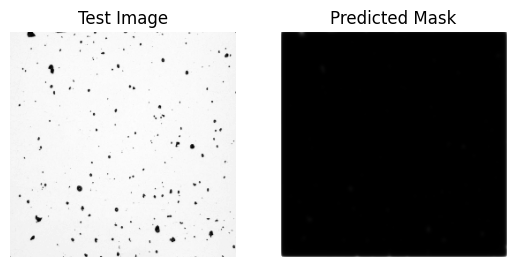

In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Load and preprocess an image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Load and preprocess a mask
def load_and_preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.float32) / 255.0
    return mask

# Load the dataset
def load_dataset(image_folder, mask_folder):
    image_paths = glob.glob(os.path.join(image_folder, '*.JPG'))
    mask_paths = glob.glob(os.path.join(mask_folder, '*.JPG'))

    X_train = []
    y_train = []

    for image_path in image_paths:
        mask_path = os.path.join(mask_folder, os.path.basename(image_path))

        image = load_and_preprocess_image(image_path)
        mask = load_and_preprocess_mask(mask_path)

        X_train.append(image)
        y_train.append(mask)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    return X_train, y_train

# U-Net model
def unet_model(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Middle
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = tf.keras.layers.concatenate([conv3, up5], axis=3)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = tf.keras.layers.concatenate([conv2, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = tf.keras.layers.concatenate([conv1, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output
    output = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model

# Define input shape (256x256 with 1 channel, as it's grayscale)
input_shape = (256, 256, 1)

# Create the U-Net model
model = unet_model(input_shape)

# Compile the model with an appropriate loss function and optimizer
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

# Load and preprocess the dataset
train_image_folder = '/content/train_images'
train_mask_folder = '/content/mask_images'
X_train, y_train = load_dataset(train_image_folder, train_mask_folder)

# Train the model using the dataset
model.fit(X_train, y_train, batch_size=16, epochs=10)

# After training, you can use the model for inference

# Example: Performing inference on a test image
test_image_path = '/content/test_images/144.JPG'
test_image = load_and_preprocess_image(test_image_path)
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))

# Display the results
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_image), cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(predicted_mask), cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


Epoch 1/10
1/1 [==============================] - 92s 92s/step - loss: 3.3534 - accuracy: 0.9322
Epoch 2/10
1/1 [==============================] - 88s 88s/step - loss: 2.8934 - accuracy: 0.9337
Epoch 3/10
1/1 [==============================] - 88s 88s/step - loss: 0.1226 - accuracy: 0.9337
Epoch 4/10
1/1 [==============================] - 87s 87s/step - loss: 0.1169 - accuracy: 0.9337
Epoch 5/10
1/1 [==============================] - 91s 91s/step - loss: 0.1169 - accuracy: 0.9337
Epoch 6/10
1/1 [==============================] - 89s 89s/step - loss: 0.1169 - accuracy: 0.9337
Epoch 7/10
1/1 [==============================] - 88s 88s/step - loss: 0.1169 - accuracy: 0.9337
Epoch 8/10
1/1 [==============================] - 87s 87s/step - loss: 0.1169 - accuracy: 0.9337
Epoch 9/10
1/1 [==============================] - 87s 87s/step - loss: 0.1169 - accuracy: 0.9337
Epoch 10/10
1/1 [==============================] - 2s 2s/step


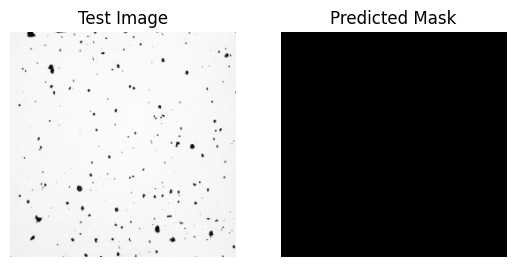

In [2]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Load and preprocess an image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Load and preprocess a mask
def load_and_preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.float32) / 255.0
    return mask

# Load the dataset
def load_dataset(image_folder, mask_folder):
    image_paths = glob.glob(os.path.join(image_folder, '*.JPG'))
    mask_paths = glob.glob(os.path.join(mask_folder, '*.JPG'))

    X_train = []
    y_train = []

    for image_path in image_paths:
        mask_path = os.path.join(mask_folder, os.path.basename(image_path))

        image = load_and_preprocess_image(image_path)
        mask = load_and_preprocess_mask(mask_path)

        X_train.append(image)
        y_train.append(mask)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    return X_train, y_train
# U-Net model
def unet_model(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Middle
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = tf.keras.layers.concatenate([conv3, up5], axis=3)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = tf.keras.layers.concatenate([conv2, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = tf.keras.layers.concatenate([conv1, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output
    output = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model

# Define input shape (256x256 with 1 channel, as it's grayscale)
input_shape = (256, 256, 1)

# Create the U-Net model
model = unet_model(input_shape)

# Compile the model with a custom loss function that applies class weighting
def weighted_binary_crossentropy(y_true, y_pred):
    weight_background = 1.0
    weight_pores = 5.0
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    loss = - (weight_background * y_true * tf.math.log(y_pred) + weight_pores * (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(loss)

model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'], run_eagerly=True)

# Load and preprocess the dataset
train_image_folder = '/content/train_images'
train_mask_folder = '/content/mask_images'
X_train, y_train = load_dataset(train_image_folder, train_mask_folder)

# Train the model using the dataset
model.fit(X_train, y_train, batch_size=16, epochs=10)

# After training, you can use the model for inference
# Example: Performing inference on a test image
test_image_path = '/content/test_images/144.JPG'
test_image = load_and_preprocess_image(test_image_path)
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))

# Display the results
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_image), cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(predicted_mask), cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


1/1 [==============================] - 2s 2s/step


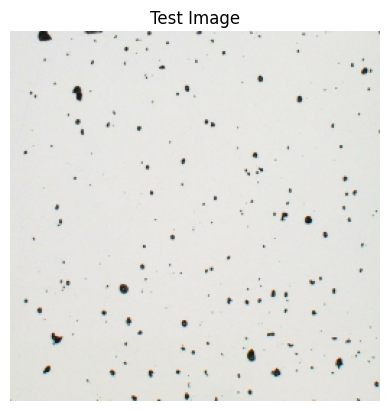

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Load and preprocess an image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Change channels to 3
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Load and preprocess a mask
def load_and_preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)  # Change channels to 3
    #mask = tf.image.rgb_to_grayscale(mask)  # Convert to grayscale
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.float32) / 255.0
    return mask

###############################################################################
# Load the dataset
def load_dataset(image_folder, mask_folder):
    image_paths = glob.glob(os.path.join(image_folder, '*.JPG'))
    mask_paths = glob.glob(os.path.join(mask_folder, '*.JPG'))

    X_train = []
    y_train = []

    for image_path in image_paths:
        mask_path = os.path.join(mask_folder, os.path.basename(image_path))

        image = load_and_preprocess_image(image_path)
        mask = load_and_preprocess_mask(mask_path)

        X_train.append(image)
        y_train.append(mask)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    return X_train, y_train
# U-Net model
def unet_model(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Middle
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = tf.keras.layers.concatenate([conv3, up5], axis=3)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = tf.keras.layers.concatenate([conv2, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = tf.keras.layers.concatenate([conv1, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output
    output = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model
###############################################################################

# Define input shape (256x256 with 3 channels for images and 1 channel for masks)
input_shape = (256, 256, 3)  # Update channels to 3

# Create the U-Net model
model = unet_model(input_shape)

# Compile the model with a custom loss function that applies class weighting
def weighted_binary_crossentropy(y_true, y_pred):
    class_weights = tf.constant([1.0, 1.0, 1.0, 1.0])  # Adjust these weights as needed

    # Compute the binary cross-entropy with the weighted class predictions
    weighted_bce = tf.keras.losses.binary_crossentropy(y_true, y_pred) * class_weights
    return weighted_bce

model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'], run_eagerly=True)

# Load and preprocess the dataset
# Load and preprocess the dataset
train_image_folder = '/content/train_images'
train_mask_folder = '/content/mask_images'
X_train, y_train = load_dataset(train_image_folder, train_mask_folder)


# After training, you can use the model for inference
# Example: Performing inference on a test image
test_image_path = '/content/test_images/144.JPG'
test_image = load_and_preprocess_image(test_image_path)
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))

# Display the results
f3 = plt.figure(1)
plt.imshow(test_image)
plt.title('Test Image')
plt.axis('off')
plt.show()




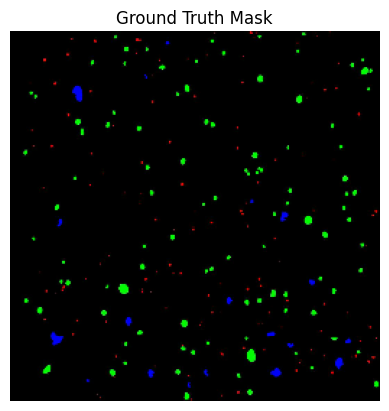

In [3]:

ground_truth_mask_path = '/content/ground_truth_masks/mask_144.JPG'
ground_truth_mask = load_and_preprocess_mask(ground_truth_mask_path)
plt.imshow(np.squeeze(ground_truth_mask))  # Use np.squeeze to remove single-dimensional entries
plt.title('Ground Truth Mask')
plt.axis('off')
plt.show()

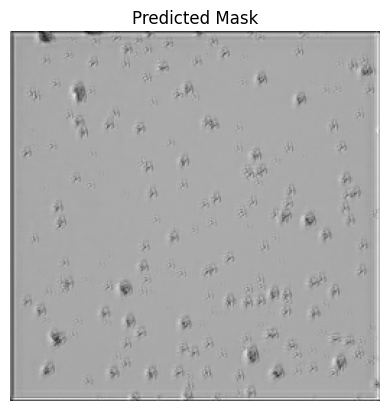

In [5]:
#plt.imshow(np.squeeze(predicted_mask))
plt.imshow(np.squeeze(predicted_mask), cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')
plt.show()

